# CSCE 623 SP 2019 Assignment 4
## NEWLIN, MARVIN
## 20190514


In [35]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

pd.set_option('display.notebook_repr_html', True)

%matplotlib inline
plt.style.use('seaborn-white')

import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

from IPython.display import Markdown as md  #enable markdown within code cell
from IPython.display import display, Math, Latex
import matplotlib as mpl
from itertools import combinations

# STEP 0:  Load Data

In [36]:
df = pd.read_csv('ISLR_Hitters.csv', index_col=0).dropna()
df.index.name = 'Player'
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, Alan Ashby to Willie Wilson
Data columns (total 20 columns):
AtBat        263 non-null int64
Hits         263 non-null int64
HmRun        263 non-null int64
Runs         263 non-null int64
RBI          263 non-null int64
Walks        263 non-null int64
Years        263 non-null int64
CAtBat       263 non-null int64
CHits        263 non-null int64
CHmRun       263 non-null int64
CRuns        263 non-null int64
CRBI         263 non-null int64
CWalks       263 non-null int64
League       263 non-null object
Division     263 non-null object
PutOuts      263 non-null int64
Assists      263 non-null int64
Errors       263 non-null int64
Salary       263 non-null float64
NewLeague    263 non-null object
dtypes: float64(1), int64(16), object(3)
memory usage: 43.1+ KB


None

In [37]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [38]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
display(dummies.info())
display(dummies.head())

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, Alan Ashby to Willie Wilson
Data columns (total 6 columns):
League_A       263 non-null uint8
League_N       263 non-null uint8
Division_E     263 non-null uint8
Division_W     263 non-null uint8
NewLeague_A    263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: uint8(6)
memory usage: 3.6+ KB


None

,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
Player,,,,,,
Alan Ashby,0,1,0,1,0,1
Alvin Davis,1,0,0,1,1,0
Andre Dawson,0,1,1,0,0,1
Andres Galarraga,0,1,1,0,0,1
Alfredo Griffin,1,0,0,1,1,0


In [39]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, Alan Ashby to Willie Wilson
Data columns (total 19 columns):
AtBat          263 non-null float64
Hits           263 non-null float64
HmRun          263 non-null float64
Runs           263 non-null float64
RBI            263 non-null float64
Walks          263 non-null float64
Years          263 non-null float64
CAtBat         263 non-null float64
CHits          263 non-null float64
CHmRun         263 non-null float64
CRuns          263 non-null float64
CRBI           263 non-null float64
CWalks         263 non-null float64
PutOuts        263 non-null float64
Assists        263 non-null float64
Errors         263 non-null float64
League_N       263 non-null uint8
Division_W     263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: float64(16), uint8(3)
memory usage: 35.7+ KB


In [40]:
display(X.head(5))

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
Player,,,,,,,,,,,,,,,,,,,
Alan Ashby,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,1,1
Alvin Davis,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,1,0
Andre Dawson,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1,0,1
Andres Galarraga,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1,0,1
Alfredo Griffin,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,0,1,0


## 0.1 Split data into test and non-test sets


In [41]:
X_nonTest, X_test, y_nonTest, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## 0.2 Scale all X data using nonTest data scaler
Scale the data features since we dont want some features to affect the linear regressions differently just becasue they have different scales

In [42]:
scaler = StandardScaler()
scaler.fit(X_nonTest)
X_nonTestScaled = scaler.transform(X_nonTest)  #non-test data scaled using non-test data mean and var
X_testScaled = scaler.transform(X_test)   #test data scaled using non-test data mean and var (prevents "learning" about the test set)

# STEP 1:  Explore the data & make prediction about features

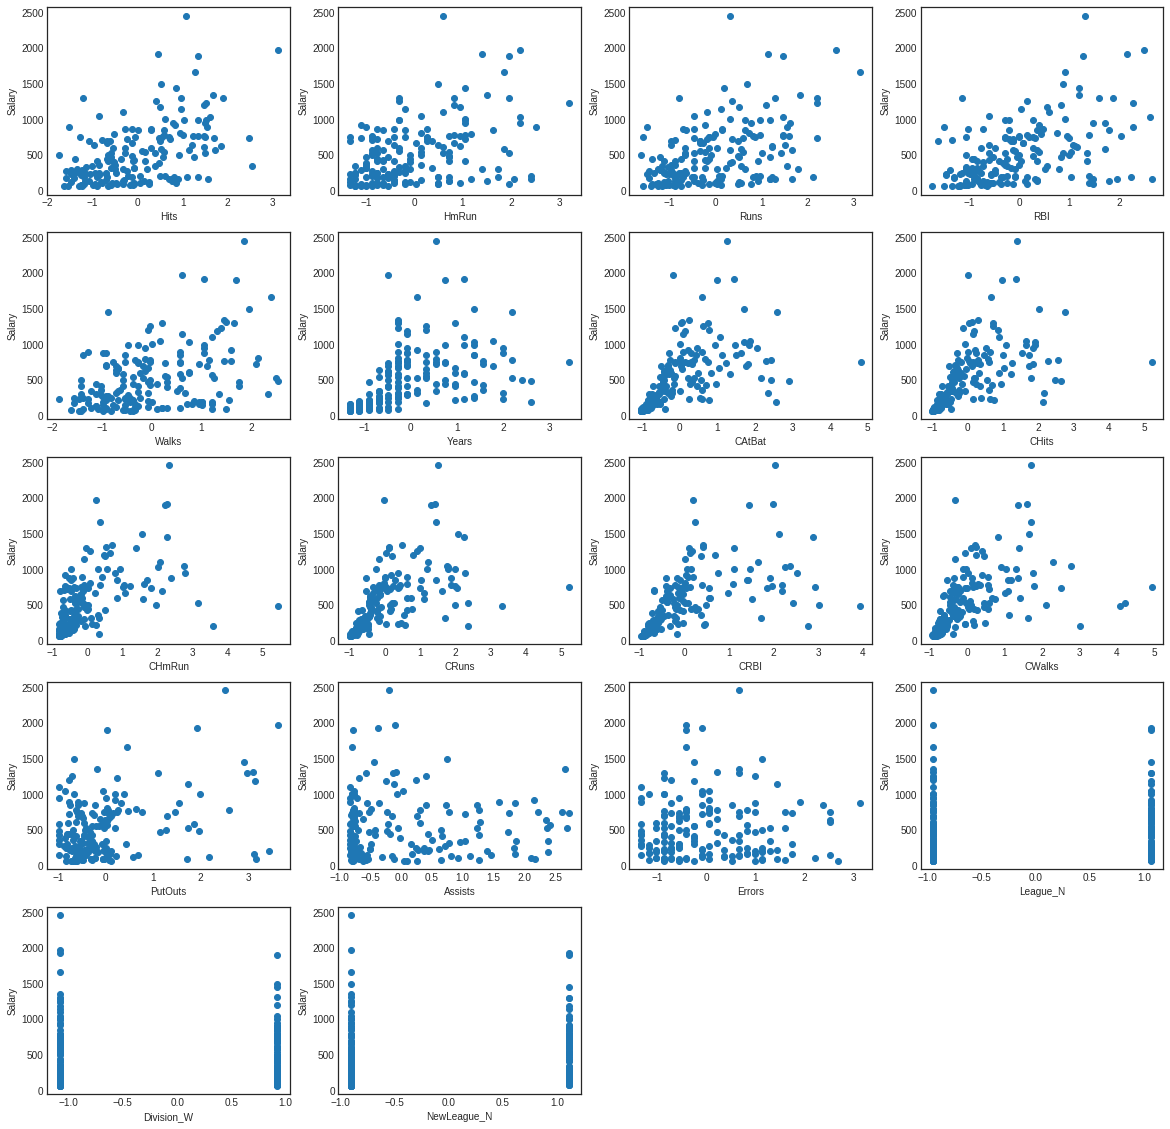

In [43]:
fig1 = plt.figure(figsize=(20,20))
grid = mpl.gridspec.GridSpec(5, 4)
subplots = []

X_nonTestScaled_df = pd.DataFrame(X_nonTestScaled, columns=X.columns)

for i in range(5):
    for j in range(4):
        curr_col = 4*i+(j+1) # convert grid position to array position
        if curr_col < len(X_nonTestScaled_df.columns):
            ax1 = plt.subplot(grid[i,j])
            ax1.scatter(X_nonTestScaled_df.iloc[:,curr_col], y_nonTest)
            ax1.set_xlabel(X_nonTestScaled_df.columns[curr_col])
            ax1.set_ylabel('Salary')
           


### Predictions
Based on the scatterplots above, the 6 features that appear to have the strongest relationship with salary are:
* Hits
* Home Runs
* Career Hits (CHits)
* Career Home Runs (CHmRuns)
* Career At Bats (CAtBat)
* Career RBI (CRBI)

These 6 features appear to have the strongest correlation with salary. The dummy variables all appear to have about an even split for salary so there doesn't appear to be a relation with salary there. Overall, the career performance numbers (Career hits, home runs, at bats, and RBIs) all appear to have the least amount of variance in the relationship between the feature and salary. 

# STEP 2:  Write Function For Best-Subset

In [44]:
def bestSubset(X_nonTest,y_nonTest, k):
    kfeatures = []  #placeholder
    kMSE = []  #placeholder
    
    # insert student code here
    features_list = X_nonTest.columns
    feature_combinations = combinations(features_list, k) # Generate p choose k combinations of features
    lin_reg = LinearRegression()
    
    #Generate the subsets: Algorithm step 2a
    for feature_set in feature_combinations:
        
        X_subset = X_nonTest.loc[:, feature_set] # Select the columns from the dataframe in the feature set
        
        #Algorithm step 2b: Select best model
        # Run 5 fold cross validation with MSE as metric using sklearn cross_validate function
        cv_results = cross_validate(lin_reg, X_subset, y_nonTest, cv=5, scoring=('neg_mean_squared_error'))
        # Calculate the mean test score from 5-fold cross validation
        avg_mse = np.abs(cv_results['test_score'].mean()) #  Take absolute value
        
        kfeatures.append(feature_set)
        kMSE.append(avg_mse)
    #End for
    kfeatures = np.array(kfeatures)
    kMSE = np.array(kMSE)
    # Return the feature set that corresponsds to minimum mse and the minimmum mse
    return (kfeatures[np.argmin(kMSE)], np.min(kMSE)) 

# STEP 3:  Execute best subset

In [25]:

best_subset_models = []

for k in range(1,7):
    mod = bestSubset(X_nonTestScaled_df, y_nonTest, k)
    best_subset_models.append(mod)



# STEP 4:  Plot of Avg Crossval MSE for 6 best models with annotated best point

In [20]:
"""
    This function creates a selected feature chart (dataframe) from the passed in model list
    It will display an 'X' in the columns for the selected feature and be empty otherwise
"""
def make_feature_chart(X_nonTest, model_list):
    features_df = pd.DataFrame(index=[1,2,3,4,5,6], columns=X_nonTestScaled_df.columns, dtype=str)
    features_df = features_df.replace(np.nan, '', regex=True)
    for feature in features_df.columns:
        for i in range(0,len(model_list)):
            mod = model_list[i]
            feat_list = mod[0]
            for j in range(len(feat_list)):
                if feat_list[j] == feature:
                    features_df.loc[i+1, feature] = 'X'
    return features_df

In [45]:
model_list = best_subset_models

for mod in model_list:
    print(mod)

# Convert to dataframe for display
best_subset_features_df = make_feature_chart(X_nonTestScaled_df, model_list)

# End for
display(md("### Table of features selected per model order for Best Subset Selection"))
display(best_subset_features_df.head(6))


(array(['CRBI'], dtype='<U11'), 128417.8054767646)
(array(['Hits', 'CRBI'], dtype='<U11'), 97700.23597422076)
(array(['Hits', 'CRBI', 'PutOuts'], dtype='<U11'), 92567.34039207702)
(array(['AtBat', 'Hits', 'CRBI', 'PutOuts'], dtype='<U11'), 88880.3963577617)
(array(['AtBat', 'Hits', 'CRBI', 'PutOuts', 'Division_W'], dtype='<U11'), 86494.41572423125)
(array(['AtBat', 'Hits', 'CRBI', 'PutOuts', 'League_N', 'Division_W'],
      dtype='<U11'), 85915.54105567104)


### Table of features selected per model order for Best Subset Selection

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
1,,,,,,,,,,,,X,,,,,,,
2,,X,,,,,,,,,,X,,,,,,,
3,,X,,,,,,,,,,X,,X,,,,,
4,X,X,,,,,,,,,,X,,X,,,,,
5,X,X,,,,,,,,,,X,,X,,,,X,
6,X,X,,,,,,,,,,X,,X,,,X,X,


### Discussion of Features Selected

The results that are not surprising are the CRBI and Hits being selected as an important feature in ever model. It is surprising that PutOuts and Division_W are selected prior to AtBat. Additionally, I was surprised at League_N being selected as an important feature in the 6 feature subset. 


### Plot of Model Order vs. MSE

In [46]:
"""
    This function plots the passed in model orders vs the passed in MSE values.
"""
def plot_model(model_order, mse_list, title, labels):
    fig = plt.figure(figsize=(8,5))
    ax1 = plt.subplot()
    for i in range(len(mse_list)):
        ax1.plot(model_order,mse_list[i], '-o')
    ax1.set_xlabel('Model Order')
    ax1.set_ylabel('Mean Squared Error')
    ax1.set_title(title)
    plt.legend(labels)

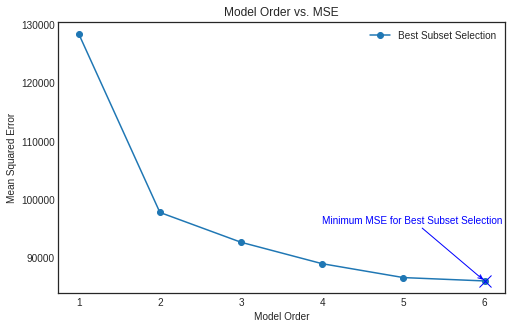

In [57]:
mse = []
for mod in model_list:
    err = mod[1]
    mse.append(err)
mods = np.arange(1,7,1)
min_x = 0
min_y = 1000000
for i in range(len(mse)):
    if mse[i] < min_y:
        min_y = mse[i]
        min_x = i+1
best_subset_min_point = (min_x, min_y)
_ = plot_model(mods, [mse], "Model Order vs. MSE", ['Best Subset Selection'])
_ = plt.plot(best_subset_min_point[0],best_subset_min_point[1], 'bx', markersize=12)
_ = plt.annotate('Minimum MSE for Best Subset Selection', xy=best_subset_min_point, xytext=(best_subset_min_point[0]-2,best_subset_min_point[1]+10000), 
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3", ec="blue"), color='blue')

# STEP 5:  Discussion of best subset models


# STEP 6:  Write Function For Forward Stepwise Subset Selection

In [48]:
"""
    This function calculates the adjusted R^2 score based upon the R^2 score, n - the number of samples
    d - the number of selected features
    Equation for adjusted R2 from R2 taken from https://www.statisticshowto.datasciencecentral.com/adjusted-r2/
"""
def calc_adjusted_r2(r2_score, n, d):
    adj_r2 = 1 - (1-r2_score)*(n-1)/(n-d-1)
    return adj_r2

In [49]:
def forwardStepwiseSubset(X_nonTest,y_nonTest, k):
    kfeatures = []  #placeholder
    kMSE = 0  #placeholder
    
    # insert student code here
    features = list(X_nonTest.columns)
    available_features = features.copy()
    selected_features = []
    lin_reg = LinearRegression()
    n = len(X_nonTest.index)                      # Number of samples for adjusted R2
    min_mse = 0
    # Build feature list of length k
    for i in range(k):
        max_adj_r2 = -1
    
        best_feature = ""
        
        model_features = selected_features.copy() # Get current model features
        for feature in available_features:        # Iterate through non selected features
            model_features.append(feature)        # Append the next feature to get val MSE
            
            # Select features from dataframe
            X_subset = X_nonTest.loc[:, model_features] # Select the columns from the dataframe in the feature set
        
        
            #Algorithm step 2b: Select best model
            # Run 5 fold cross validation with MSE as metric using sklearn cross_validate function
            cv_results = cross_validate(lin_reg, X_subset, y_nonTest, cv=5, 
                                        scoring=('r2', 'neg_mean_squared_error'))
            
            # Calculate the mean test score from 5-fold cross validation
            avg_r2 = cv_results['test_r2'].mean()
            avg_adj_r2 = calc_adjusted_r2(avg_r2, n, len(model_features))
            avg_mse = -cv_results['test_neg_mean_squared_error'].mean()
            # Select best adjusted R2 Score
            if avg_adj_r2 > max_adj_r2:
                max_adj_r2 = avg_adj_r2
                min_mse = avg_mse
                best_feature = feature # Select current best feature
            # Reset model features
            model_features.remove(feature)
        # End for
        
        # Add best feature to selected features
        selected_features.append(best_feature)
        available_features.remove(best_feature)
    # End for
    kfeatures = selected_features.copy()
    kMSE = min_mse
    return (kfeatures, kMSE) 

# STEP 7:  Execute Forward subset

In [50]:
fwd_subset_model_list = []
for i in range(1,7):
    fwd_mod = forwardStepwiseSubset(X_nonTestScaled_df,y_nonTest, i)
    fwd_subset_model_list.append(fwd_mod)

# Convert to dataframe for display
fwd_features_df = make_feature_chart(X_nonTestScaled_df, model_list)

# End for
display(md("### Table of features selected per model order for Forward Subset Selection"))
display(fwd_features_df.head(6))

### Table of features selected per model order for Forward Subset Selection

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
1,,,,,,,,,,,,X,,,,,,,
2,,X,,,,,,,,,,X,,,,,,,
3,,X,,,,,,,,,,X,,X,,,,,
4,X,X,,,,,,,,,,X,,X,,,,,
5,X,X,,,,,,,,,,X,,X,,,,X,
6,X,X,,,,,,,,,,X,,X,,,X,X,


As we can see above, the features selected for Forward Subset Selection at each point are identical to the features selected for Best Subset Selection. Since we fit these models with the same method, the MSE values with most likely be identical as well.



# STEP 8:  Updated Plot of Avg Crossval MSE & best points

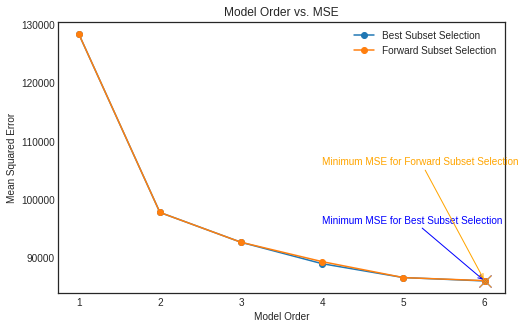

In [66]:
fwd_mse = []
min_x = 0
min_y = 100000000
for i in range(len(fwd_subset_model_list)):
    model = fwd_subset_model_list[i]
    fwd_mse.append(model[1])
    if model[1] < min_y:
        min_y = model[1]
        min_x = i+1
fwd_subset_min_point = (min_x, min_y)
        
        
        
_ = plot_model(mods, [mse, fwd_mse], "Model Order vs. MSE", ['Best Subset Selection', 'Forward Subset Selection'])
_ = plt.plot(best_subset_min_point[0],best_subset_min_point[1], 'bx', markersize=12)
_ = plt.plot(fwd_subset_min_point[0],fwd_subset_min_point[1], 'x', markersize=12, color='orange')
_ = plt.annotate('Minimum MSE for Best Subset Selection', xy=best_subset_min_point, xytext=(best_subset_min_point[0]-2,best_subset_min_point[1]+10000), 
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3", ec="blue"), color='blue')
_ = plt.annotate('Minimum MSE for Forward Subset Selection', xy=fwd_subset_min_point, xytext=(fwd_subset_min_point[0]-2,fwd_subset_min_point[1]+20000), 
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3", ec="orange"), color='orange')

# STEP 9:  Discussion of best foward-stepwise models 

As we can see from above, the forward subset selection and the best subset selection MSE and model orders are identical in both the MSE values and the minimum point. The x marker indicates the minimum point.

# STEP 10: Discussion and comparison of subset selection methods

# STEP 11: Write a function to execute LASSO

In [29]:
def LASSOSubset(X_nonTest,y_nonTest, k):
    #example of logarithmically spaced alphas for LASSO... may need tweaking
    # Tweaked to follow in class example alpha grid code
    minalpha = -3
    maxalpha = 4
    alphas = np.logspace(minalpha,maxalpha,num=1000)
    
    kfeatures = [] #placeholder
    kMSE=np.inf  #placeholder
    kalpha = 0  #placeholder
    
    # insert student code here
    num_non_zero_coeff = 0
    non_zero_coeff_list = []
    avg_mse = 0
    for alpha in alphas:
        lasso = Lasso(alpha=alpha).fit(X_nonTest, y_nonTest)
        
        # Find number of non zero coefficients
        num_non_zero_coeff = np.count_nonzero(lasso.coef_)
        
        # If number of non zero coeffs is k then stop the alpha sweep
        # and perform cross val with the selected features
        if num_non_zero_coeff == k:
            kalpha = alpha
            
            for i in range(len(lasso.coef_)):
                if lasso.coef_[i] != 0:
                    non_zero_coeff_list.append(X_nonTest.columns[i])
                    
            X_subset = X_nonTest.loc[:, non_zero_coeff_list] # Select the non zero feature(s)
            cv_results = cross_validate(lasso, X_subset, y_nonTest, cv=5, 
                                   scoring=('r2', 'neg_mean_squared_error'))
            avg_mse = -cv_results['test_neg_mean_squared_error'].mean()
            break
    # End For  
    
            
    # If the MSE is the minimum so far then set values for return
    kMSE = avg_mse
    kfeatures = non_zero_coeff_list
            
    return (kfeatures, kMSE, kalpha) 

# STEP 12: Execute LASSO

In [33]:
lasso_models = []
for k in range(1,7):
    mod = LASSOSubset(X_nonTestScaled_df,y_nonTest, k)
    lasso_models.append(mod)
    print("Features: {}, MSE: {}, alpha: {}".format(mod[0], mod[1], mod[2]))

lasso_features = make_feature_chart(X_nonTestScaled_df, lasso_models)

display(md("### Table of features selected per model order for Best Subset Selection"))
display(lasso_features.head(6))

Features: ['CRuns'], MSE: 186166.5850348003, alpha: 252.58200269627847
Features: ['CRuns', 'CRBI'], MSE: 167817.81262973248, alpha: 208.12215699863373
Features: ['Hits', 'CRuns', 'CRBI'], MSE: 122482.48933882709, alpha: 122.20446866314887
Features: ['Hits', 'CRuns', 'CRBI', 'PutOuts'], MSE: 103029.17652290061, alpha: 65.13490946272796
Features: ['Hits', 'CHmRun', 'CRuns', 'CRBI', 'PutOuts'], MSE: 103371.22787981256, alpha: 55.429855156846635
Features: ['Hits', 'CHmRun', 'CRuns', 'CRBI', 'PutOuts', 'Division_W'], MSE: 103246.14898506617, alpha: 53.66976945540476


### Table of features selected per model order for Best Subset Selection

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
1,,,,,,,,,,,X,,,,,,,,
2,,,,,,,,,,,X,X,,,,,,,
3,,X,,,,,,,,,X,X,,,,,,,
4,,X,,,,,,,,,X,X,,X,,,,,
5,,X,,,,,,,,X,X,X,,X,,,,,
6,,X,,,,,,,,X,X,X,,X,,,,X,


# STEP 13: Updated Plot of Avg Crossval MSE & best points

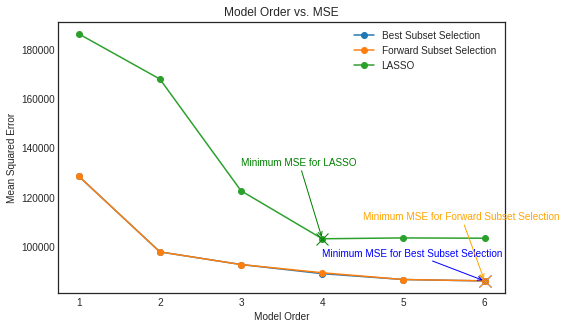

In [65]:
lasso_mse = []
min_x = 0
min_y = 100000000
for i in range(len(lasso_models)):
    model = lasso_models[i]
    lasso_mse.append(model[1])
    if model[1] < min_y:
        min_y = model[1]
        min_x = i+1
lasso_min_point = (min_x, min_y)

_ = plot_model(mods, [mse, fwd_mse, lasso_mse], "Model Order vs. MSE", 
               ['Best Subset Selection', 'Forward Subset Selection', 'LASSO'])
_ = plt.plot(best_subset_min_point[0],best_subset_min_point[1], 'bx', markersize=12)
_ = plt.plot(fwd_subset_min_point[0],fwd_subset_min_point[1], 'x', markersize=12, color='orange')
_ = plt.plot(lasso_min_point[0],lasso_min_point[1], 'gx', markersize=12, label='Minimum MSE')
_ = plt.annotate('Minimum MSE for Best Subset Selection', xy=best_subset_min_point, xytext=(best_subset_min_point[0]-2,best_subset_min_point[1]+10000), 
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3", ec="blue"), color='blue')
_ = plt.annotate('Minimum MSE for Forward Subset Selection', xy=fwd_subset_min_point, xytext=(fwd_subset_min_point[0]-1.5,fwd_subset_min_point[1]+25000), 
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3", ec="orange"), color='orange')
_ = plt.annotate('Minimum MSE for LASSO', xy=lasso_min_point, xytext=(lasso_min_point[0]-1,lasso_min_point[1]+30000), 
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3", ec="green"), color='green')

# STEP 14: Discussion of best LASSO models 

As we can see in the plot above, the LASSO method has a higher overall MSE. We see that it starts out very high, significantly higher than the other 2 methods. It then quickly decreases to its minimum point at 4 features. The corresponding values for the 4 feature model are:

* Model Order: 4
* Features: ['Hits', 'CRuns', 'CRBI', 'PutOuts']
* MSE: 103029.1765
* Alpha: 65.1349

The 5 and 6 feature models have roughly the same, but slightly higher MSE values. This is different from the subset selection methods where the MSE decreases with each feature added to the model. 

The significant MSE increase makes sense due to the high values of alpha that correspond with the lower feature models. Since the LASSO model is trying to minimize RSS along with the alpha penalty, we expect the higher MSE with the coefficients that come out of the alpha sweep. 

From the table above in step 13, we see that the features selected by LASSO for model order 4 are Hits, CRuns, CRBI, and PutOuts. Only 2 of these were in my inital prediction of the features that I thought would be selected and they are Hits and CRBI. 

## Best Overall Model Selection

Since the Forward Subset Selection method had the best performance on the non test set and fastest runtime, the Forward Subset selection method is the best method. We will now test its performance on the test set. 

# STEP 15: Answer Customer Questions

## a

## b

END OF ASSIGNMENT